In [81]:
# bibliotecas
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
# Configuração de estilo dos gráficos
sns.set(style="whitegrid")
plt.style.use("ggplot")

In [85]:
# Caminho base
base_path = r"C:\Users\Vitor\Documents\Vitor\Desafio\archive"

In [87]:
# Lista de arquivos
files = {
    "customers": "olist_customers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "order_payments": "olist_order_payments_dataset.csv",
    "order_reviews": "olist_order_reviews_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "products": "olist_products_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "product_translation": "product_category_name_translation.csv"
}

# Dicionário para armazenar DataFrames
dfs = {}

In [89]:
for key, file in files.items():
    path = os.path.join(base_path, file)
    dfs[key] = pd.read_csv(path)
    print(f"{key} carregado com {dfs[key].shape[0]} linhas e {dfs[key].shape[1]} colunas.")

customers carregado com 99441 linhas e 5 colunas.
geolocation carregado com 1000163 linhas e 5 colunas.
order_items carregado com 112650 linhas e 7 colunas.
order_payments carregado com 103886 linhas e 5 colunas.
order_reviews carregado com 99224 linhas e 7 colunas.
orders carregado com 99441 linhas e 8 colunas.
products carregado com 32951 linhas e 9 colunas.
sellers carregado com 3095 linhas e 4 colunas.
product_translation carregado com 71 linhas e 2 colunas.


In [90]:
# Visualizar valores nulos por tabela
for name, df in dfs.items():
    print(f"\n{name.upper()} - Valores nulos:")
    print(df.isnull().sum())


CUSTOMERS - Valores nulos:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

GEOLOCATION - Valores nulos:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

ORDER_ITEMS - Valores nulos:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

ORDER_PAYMENTS - Valores nulos:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

ORDER_REVIEWS - Valores nulos:
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_cre

In [91]:
# Limpeza da tabela orders
orders = dfs['orders'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [92]:
# Verificar e remover duplicatas em todas as tabelas
for name, df in dfs.items():
    dupli = df.duplicated().sum()
    if dupli > 0:
        print(f"{name}: Removendo {dupli} duplicatas.")
        dfs[name] = df.drop_duplicates()

geolocation: Removendo 261831 duplicatas.


In [93]:
# Normalizar nomes de categorias (juntar com tradução)
products = dfs["products"].merge(
    dfs["product_translation"],
    on="product_category_name",
    how="left"
)

In [94]:
df_modelo = (
    dfs["customers"]
    .merge(orders, on="customer_id", how="inner")
    .merge(dfs["order_items"], on="order_id", how="inner")
    .merge(products, on="product_id", how="inner")
    .merge(dfs["sellers"], on="seller_id", how="inner")
    .merge(dfs["order_payments"], on="order_id", how="left")
    .merge(dfs["order_reviews"], on="order_id", how="left")
)

print("\nModelo relacional criado com shape:", df_modelo.shape)


Modelo relacional criado com shape: (118310, 40)


In [95]:
df_modelo.to_csv(os.path.join(base_path, "base_relacional_completa.csv"), index=False)

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps

# Dataset relacional já criado na Etapa 1
df = pd.read_csv(r"C:\Users\Vitor\Documents\Vitor\Desafio\archive\base_relacional_completa.csv")
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])


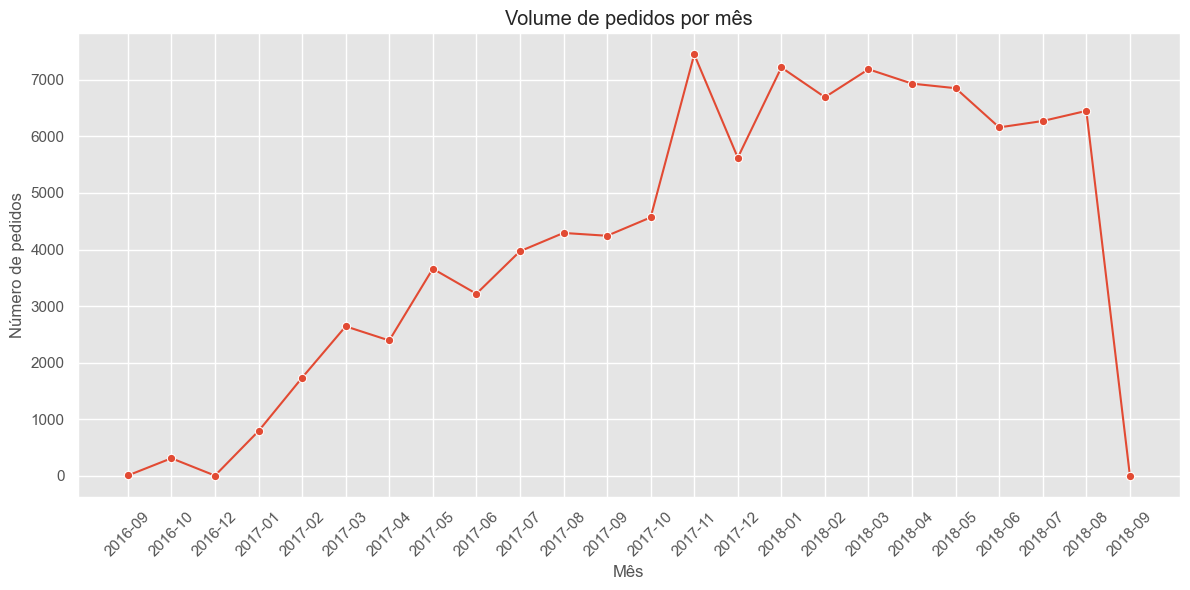

In [112]:
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')

pedidos_mensais = df.groupby('order_month')['order_id'].nunique().reset_index()
pedidos_mensais['order_month'] = pedidos_mensais['order_month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=pedidos_mensais, x='order_month', y='order_id', marker='o')
plt.xticks(rotation=45)
plt.title('Volume de pedidos por mês')
plt.xlabel('Mês')
plt.ylabel('Número de pedidos')
plt.tight_layout()
plt.show()


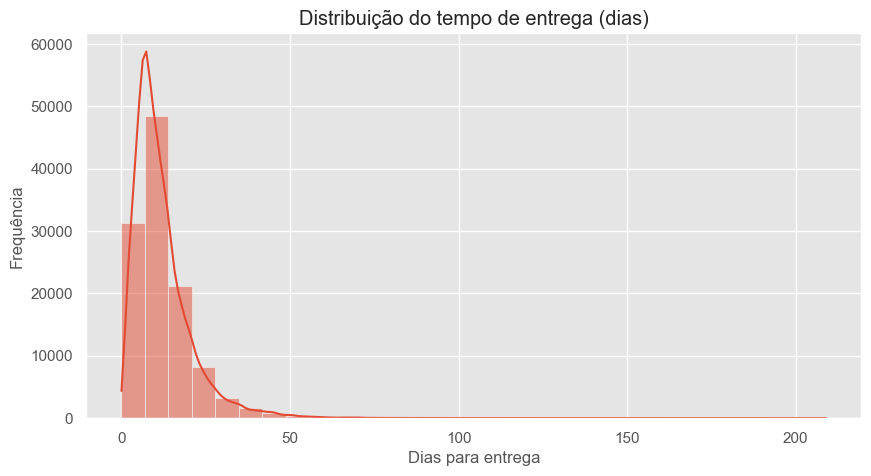

In [114]:
df['tempo_entrega'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

plt.figure(figsize=(10, 5))
sns.histplot(df['tempo_entrega'].dropna(), bins=30, kde=True)
plt.title('Distribuição do tempo de entrega (dias)')
plt.xlabel('Dias para entrega')
plt.ylabel('Frequência')
plt.show()


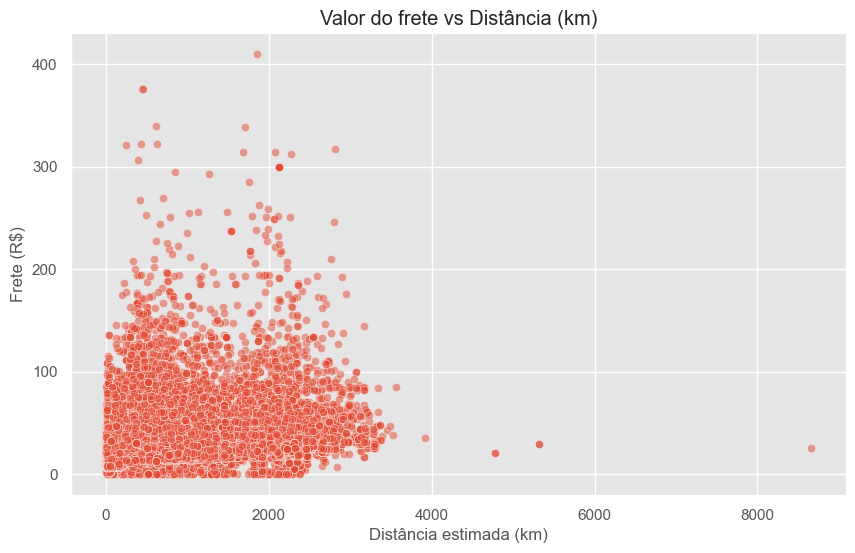

In [120]:
from geopy.distance import geodesic

# Selecionar lat/long dos sellers e clientes
sellers = df[['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']].drop_duplicates()
customers = df[['customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']].drop_duplicates()
geolocation = pd.read_csv(r"C:\Users\Vitor\Documents\Vitor\Desafio\archive\olist_geolocation_dataset.csv")

# Agrupar por média de coordenadas por CEP
geo_grouped = geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean()

# Associar localizações
sellers = sellers.merge(geo_grouped, left_on='seller_zip_code_prefix', right_index=True)
customers = customers.merge(geo_grouped, left_on='customer_zip_code_prefix', right_index=True)

# Unir com dados principais
df_geo = df.merge(customers[['customer_id', 'geolocation_lat', 'geolocation_lng']], on='customer_id', how='left')
df_geo = df_geo.merge(sellers[['seller_id', 'geolocation_lat', 'geolocation_lng']], on='seller_id', how='left', suffixes=('_cliente', '_seller'))

# Calcular distância
def calcular_distancia(row):
    try:
        return geodesic((row['geolocation_lat_cliente'], row['geolocation_lng_cliente']),
                        (row['geolocation_lat_seller'], row['geolocation_lng_seller'])).km
    except:
        return None

df_geo['distancia_km'] = df_geo.apply(calcular_distancia, axis=1)

# Correlação entre distância e frete
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_geo, x='distancia_km', y='freight_value', alpha=0.5)
plt.title('Valor do frete vs Distância (km)')
plt.xlabel('Distância estimada (km)')
plt.ylabel('Frete (R$)')
plt.show()


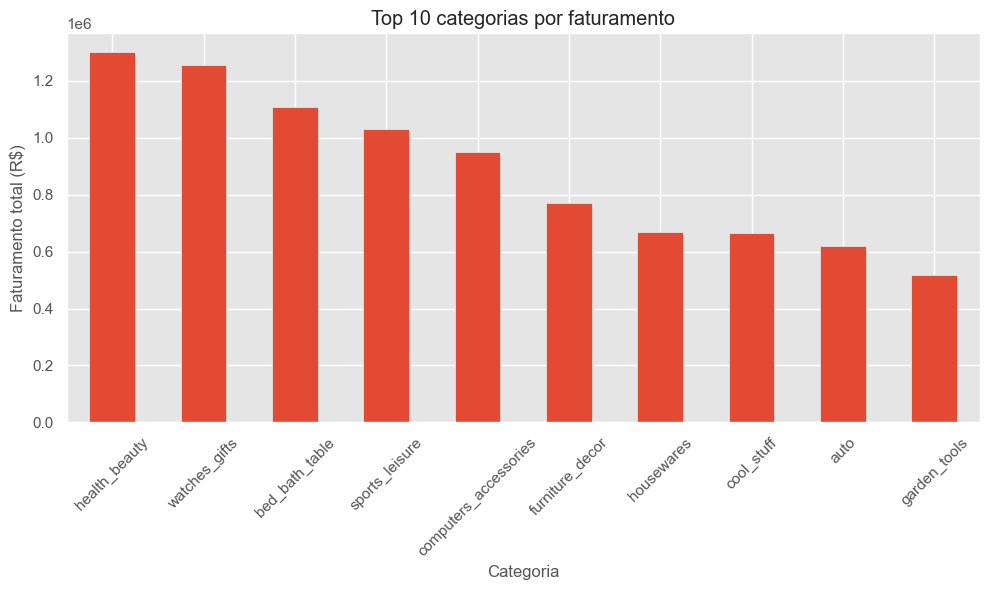

In [122]:
faturamento_categoria = df.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
faturamento_categoria.plot(kind='bar')
plt.title('Top 10 categorias por faturamento')
plt.xlabel('Categoria')
plt.ylabel('Faturamento total (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


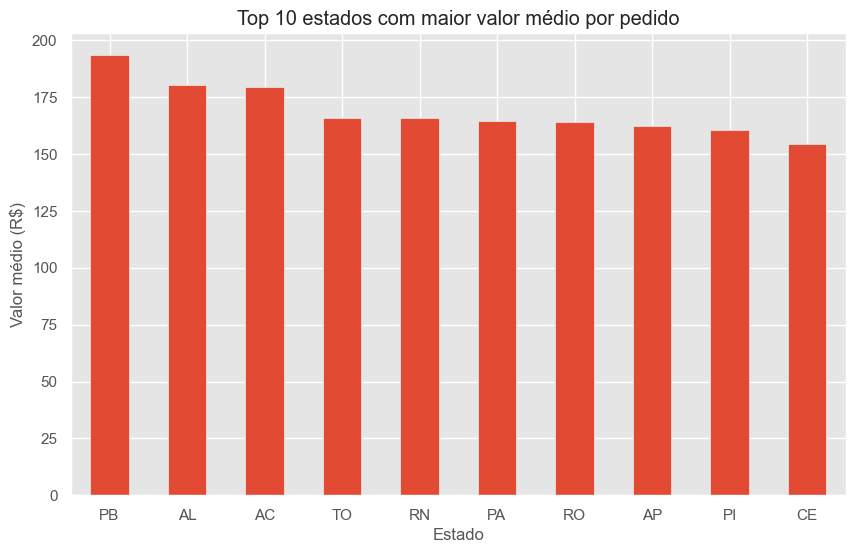

In [124]:
valor_medio_estado = df.groupby('customer_state')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
valor_medio_estado.plot(kind='bar')
plt.title('Top 10 estados com maior valor médio por pedido')
plt.xlabel('Estado')
plt.ylabel('Valor médio (R$)')
plt.xticks(rotation=0)
plt.show()
